# Regressão - Concreto com Fibras (com dados injetados)
Notebook com os dados originais injetados em uma célula para execução offline.

In [1]:
# Importações e configurações iniciais (TensorFlow removido para compatibilidade)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import RidgeCV
import warnings
warnings.filterwarnings('ignore')
plt.style.use('default')
plt.rcParams['figure.figsize'] = (10, 6)


In [2]:
import pandas as pd

# Leitura robusta da planilha, detectando automaticamente a linha do cabeçalho real
df_temp = pd.read_excel("teste banco de dados.xlsx", header=None)
header_row = df_temp[df_temp.apply(lambda x: x.astype(str).str.contains("Tipo do concreto", case=False, na=False)).any(axis=1)].index[0]
df = pd.read_excel("teste banco de dados.xlsx", header=header_row)
df = df.dropna(axis=1, how="all")

print("Colunas reconhecidas:")
print(df.columns.tolist())


Colunas reconhecidas:
['Tipo do concreto', 'fck (resistência)            [MPa]', 'l (comprimento)            [mm]', 'd (diâmetro            [mm]', 'l/d      (fator de forma             ', 'Teor de fibra (%)', 'N (ganchos)', 'fR,1 (N/mm²)      (experimental)', 'fR,3 (N/mm²)      (experimental)']


Coluna alvo escolhida: fR,1 (N/mm²)      (experimental)
RandomForest - MSE: 1.3674641514157053 MAE: 0.7427436304916345 R2: 0.8094992347500954
Ridge  - MSE: 1.8026915218057473 MAE: 1.0151592328110262 R2: 0.7488679216504646

Equação estimada (termos em unidades originais):
y = -2.98224 +0.0614239 * fck (resistência)            [MPa] +0.015829 * l (comprimento)            [mm] -0.990755 * d (diâmetro            [mm] +0.0191458 * l/d      (fator de forma              +6.82444 * Teor de fibra (%) +0.320201 * N (ganchos)

Modelos salvos: model_rf.joblib, model_lr.joblib, scaler_X.joblib


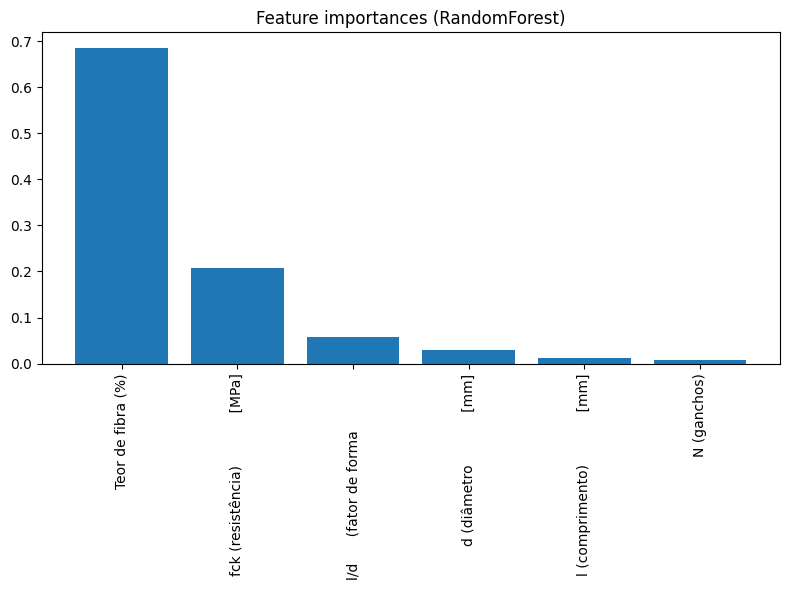

In [3]:
# Treinamento usando exatamente as variáveis especificadas e alvo fR,1/fR,3
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import RidgeCV
import joblib
import re

# 1) Selecionar o alvo: prioriza fR,1; se não existir, usa fR,3
prefer_targets = [
    'fR,1 (N/mm²)      (experimental)',
    'fR,3 (N/mm²)      (experimental)'
]
existing_targets = [c for c in prefer_targets if c in df.columns]
if not existing_targets:
    raise ValueError('Nenhuma coluna de alvo fR,1 ou fR,3 encontrada na planilha.')
target_col = existing_targets[0]
print('Coluna alvo escolhida:', target_col)

# 2) Selecionar exatamente estas features na ordem desejada
ordered_features = [
    'fck (resistência)            [MPa]',
    'l (comprimento)            [mm]',
    'd (diâmetro            [mm]',
    'l/d      (fator de forma             ',
    'Teor de fibra (%)',
    'N (ganchos)'
]
missing = [c for c in ordered_features if c not in df.columns]
if missing:
    raise ValueError(f'As seguintes colunas esperadas não foram encontradas no Excel: {missing}')

# 3) Converter para numérico (exceto a categórica "Tipo do concreto")
def to_numeric_series(s):
    return pd.to_numeric(s.astype(str).str.replace(',', '.').str.replace('[^0-9\.-]', '', regex=True), errors='coerce')

work = df.copy()
for c in ordered_features:
    work[c] = to_numeric_series(work[c])

# 4) Montar X e y apenas com as 6 variáveis e o alvo
keep_cols = ordered_features + [target_col]
work = work[keep_cols].dropna(subset=[target_col])

feature_cols = ordered_features  # fixar a lista final de features

# Validações de sanidade: garantir que nenhum fR,* virou feature
illegal_feats = [c for c in feature_cols if re.search(r'(?i)f\s*R\s*[,/]*\s*(1|3)', c)]
if illegal_feats:
    raise AssertionError(f"As seguintes colunas são alvos e não devem estar em feature_cols: {illegal_feats}")

X = work[feature_cols].copy()
y = work[target_col].copy()

# Preencher NaNs com mediana das respectivas colunas
X = X.fillna(X.median(numeric_only=True))

# 5) Split e escala
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)

# 6) Treinar RandomForest
rf = RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1)
rf.fit(X_train_s, y_train)
y_pred_rf = rf.predict(X_test_s)
mse_rf = mean_squared_error(y_test, y_pred_rf)
mae_rf = mean_absolute_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)
print('RandomForest - MSE:', mse_rf, 'MAE:', mae_rf, 'R2:', r2_rf)

# 7) Treinar Ridge e recuperar coeficientes em unidades originais
lr = RidgeCV(alphas=(0.1, 1.0, 10.0))
lr.fit(X_train_s, y_train)
y_pred_lr = lr.predict(X_test_s)
mse_lr = mean_squared_error(y_test, y_pred_lr)
mae_lr = mean_absolute_error(y_test, y_pred_lr)
r2_lr = r2_score(y_test, y_pred_lr)
print('Ridge  - MSE:', mse_lr, 'MAE:', mae_lr, 'R2:', r2_lr)

means = scaler.mean_
scales = scaler.scale_
coef_scaled = lr.coef_
intercept = lr.intercept_

adjusted_coefs = coef_scaled / scales
adjusted_intercept = intercept - (coef_scaled * (means / scales)).sum()

# 8) Equação formatada com nomes originais
terms = [f'{adjusted_coefs[i]:+.6g} * {feature_cols[i]}' for i in range(len(feature_cols))]
equation = f'y = {adjusted_intercept:.6g} ' + ' '.join(terms)
print('\nEquação estimada (termos em unidades originais):')
print(equation)

# 9) Salvar modelos e scaler
joblib.dump(rf, 'model_rf.joblib')
joblib.dump(lr, 'model_lr.joblib')
joblib.dump(scaler, 'scaler_X.joblib')
print('\nModelos salvos: model_rf.joblib, model_lr.joblib, scaler_X.joblib')

# 10) Feature importances (RandomForest)
import matplotlib.pyplot as plt
import numpy as np
importances = rf.feature_importances_
idx = np.argsort(importances)[::-1]
plt.figure(figsize=(8,6))
plt.bar([feature_cols[i] for i in idx], importances[idx])
plt.xticks(rotation=90)
plt.title('Feature importances (RandomForest)')
plt.tight_layout()
plt.show()

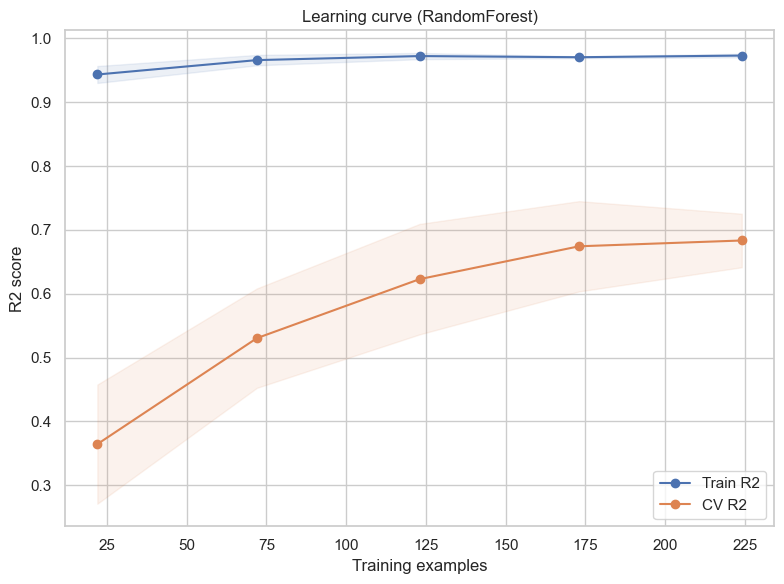

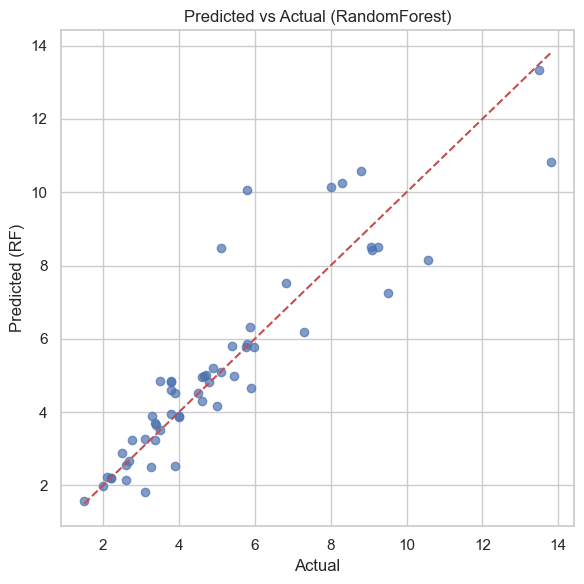

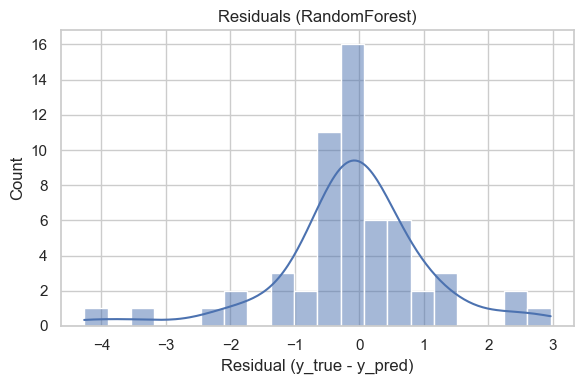

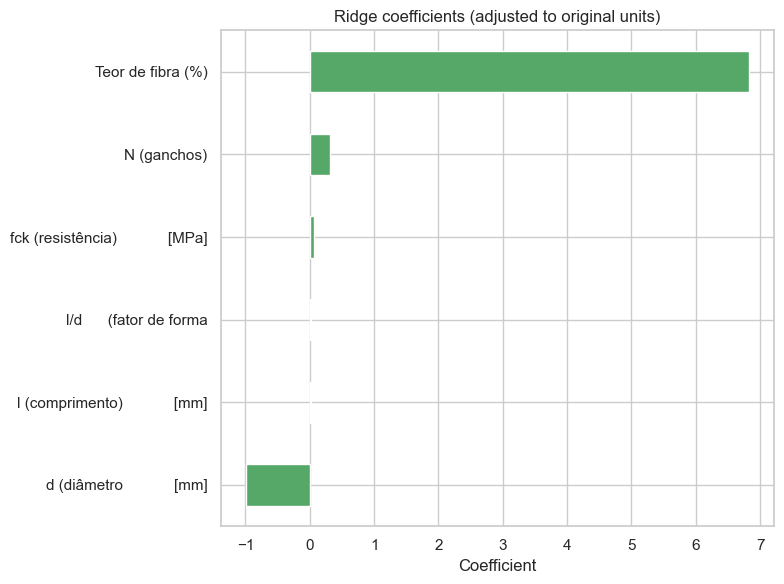

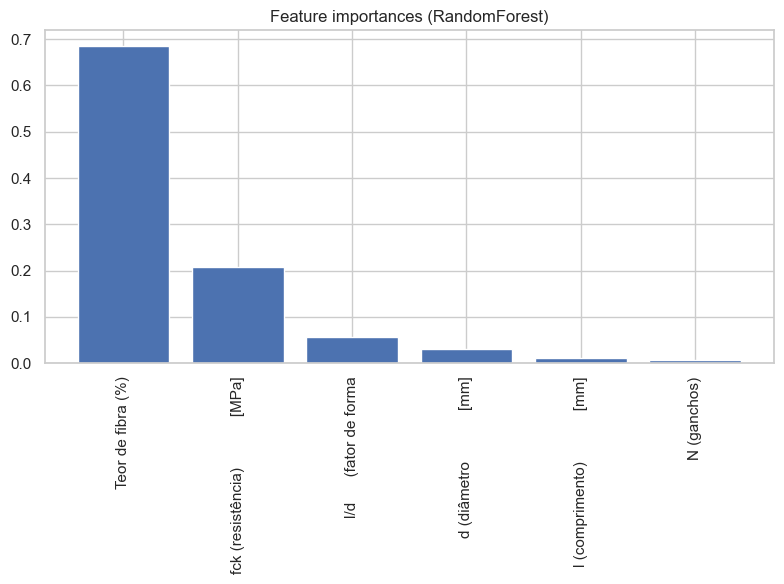

Equação formatada salva em equation.txt
y = -2.98224
 + 0.0614239 * fck (resistência)            [MPa]
 + 0.015829 * l (comprimento)            [mm]
 - 0.990755 * d (diâmetro            [mm]
 + 0.0191458 * l/d      (fator de forma
 + 6.82444 * Teor de fibra (%)
 + 0.320201 * N (ganchos)
learning_curve_rf.png -> EXISTS
predicted_vs_actual_rf.png -> EXISTS
residuals_rf.png -> EXISTS
coefficients_ridge.png -> EXISTS
feature_importances_rf.png -> EXISTS
equation.txt -> EXISTS


In [4]:
# Visualizações de treino e formatação da equação (salva imagens e arquivo de texto)
import os
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid')

# 1) Learning curve (R2) para RandomForest
plt.figure(figsize=(8,6))
train_sizes, train_scores, test_scores = learning_curve(rf, X, y, cv=5, scoring='r2', n_jobs=-1, train_sizes=np.linspace(0.1,1.0,5))
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)
plt.plot(train_sizes, train_mean, 'o-', color='C0', label='Train R2')
plt.fill_between(train_sizes, train_mean-train_std, train_mean+train_std, alpha=0.1, color='C0')
plt.plot(train_sizes, test_mean, 'o-', color='C1', label='CV R2')
plt.fill_between(train_sizes, test_mean-test_std, test_mean+test_std, alpha=0.1, color='C1')
plt.xlabel('Training examples')
plt.ylabel('R2 score')
plt.legend()
plt.title('Learning curve (RandomForest)')
plt.tight_layout()
plt.savefig('learning_curve_rf.png', dpi=150)
plt.show()

# 2) Predicted vs Actual (test set) - RandomForest
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred_rf, alpha=0.7)
mn = min(min(y_test), min(y_pred_rf))
mx = max(max(y_test), max(y_pred_rf))
plt.plot([mn,mx],[mn,mx], 'r--')
plt.xlabel('Actual')
plt.ylabel('Predicted (RF)')
plt.title('Predicted vs Actual (RandomForest)')
plt.tight_layout()
plt.savefig('predicted_vs_actual_rf.png', dpi=150)
plt.show()

# 3) Residuals (test set) - RandomForest
residuals = y_test - y_pred_rf
plt.figure(figsize=(6,4))
sns.histplot(residuals, kde=True)
plt.xlabel('Residual (y_true - y_pred)')
plt.title('Residuals (RandomForest)')
plt.tight_layout()
plt.savefig('residuals_rf.png', dpi=150)
plt.show()

# 4) Coefficients (Ridge) - mostrar como barra e salvar
feat_names = [str(f).replace('_', ' ').strip() for f in feature_cols]
coef_vals = adjusted_coefs
coef_df = pd.Series(coef_vals, index=feat_names).sort_values()
plt.figure(figsize=(8,6))
coef_df.plot(kind='barh', color='C2')
plt.title('Ridge coefficients (adjusted to original units)')
plt.xlabel('Coefficient')
plt.tight_layout()
plt.savefig('coefficients_ridge.png', dpi=150)
plt.show()

# 5) Feature importances já salvas anteriormente; garantir arquivo
try:
    plt.figure(figsize=(8,6))
    importances = rf.feature_importances_
    idx = np.argsort(importances)[::-1]
    plt.bar([feat_names[i] for i in idx], importances[idx])
    plt.xticks(rotation=90)
    plt.title('Feature importances (RandomForest)')
    plt.tight_layout()
    plt.savefig('feature_importances_rf.png', dpi=150)
    plt.show()
except Exception as e:
    print('Erro ao salvar feature importances:', e)

# 6) Escrever equação formatada em arquivo (uma linha por termo)
nice_terms = []
for i, n in enumerate(feat_names):
    coef = adjusted_coefs[i]
    sign = '+' if coef >= 0 else '-'
    nice_terms.append(f' {sign} {abs(coef):.6g} * {n}')
nice_eq = f'y = {adjusted_intercept:.6g}' + '\n' + '\n'.join(nice_terms)
with open('equation.txt', 'w', encoding='utf-8') as f:
    f.write('Equação estimada (unidades originais):\n')
    f.write(nice_eq)
print('Equação formatada salva em equation.txt')
print(nice_eq)

# Indicar arquivos salvos
files = ['learning_curve_rf.png','predicted_vs_actual_rf.png','residuals_rf.png','coefficients_ridge.png','feature_importances_rf.png','equation.txt']
for fn in files:
    print(fn, '->', 'EXISTS' if os.path.exists(fn) else 'MISSING')


In [5]:
# Plot da equação estimada comparada com RandomForest e renderizar a equação no gráfico
import numpy as np
import matplotlib.pyplot as plt
import os

# Escolher a feature principal pela magnitude do coeficiente ajustado
main_idx = int(np.argmax(np.abs(adjusted_coefs))) if len(adjusted_coefs)>0 else 0
main_feat = feature_cols[main_idx]
print('Feature principal para plot:', main_feat)

# Gerar grid para a feature principal mantendo outras no valor mediano
grid = np.linspace(X[main_feat].min(), X[main_feat].max(), 300)

Feature principal para plot: Teor de fibra (%)


In [6]:
# Equação formatada (LaTeX) e imagem pronta para relatório
from IPython.display import Math, display
import matplotlib.pyplot as plt

# Rótulo de y de acordo com o alvo escolhido
if 'target_col' in globals():
    if 'fR,1' in str(target_col):
        y_label = r'f_{R,1}\,(\mathrm{N/mm^2})'
    elif 'fR,3' in str(target_col):
        y_label = r'f_{R,3}\,(\mathrm{N/mm^2})'
    else:
        y_label = r'y'
else:
    y_label = r'y'

# Mapa de símbolos para LaTeX
symbol_map = {
    'fck (resistência)            [MPa]': r'f_{ck}\,[\mathrm{MPa}]',
    'l (comprimento)            [mm]': r'l\,[\mathrm{mm}]',
    'd (diâmetro            [mm]': r'd\,[\mathrm{mm}]',
    'l/d      (fator de forma             ': r'\ell/d',
    'Teor de fibra (%)': r'\mathrm{TF}\,(\%)',
    'N (ganchos)': r'N_{gancho}',
}

# Construir LaTeX da equação: y = b0 + sum(bi * xi)
terms_tex = []
for i, feat in enumerate(feature_cols):
    coef = adjusted_coefs[i]
    sym = symbol_map.get(feat, feat.replace('_',' '))
    sign = '+' if coef >= 0 else '-'
    terms_tex.append(f" {sign} {abs(coef):.6g} \, {sym}")

latex_eq = rf"{y_label} = " + f"{adjusted_intercept:.6g}" + ''.join(terms_tex)

# Renderizar na célula
display(Math(latex_eq))

# Salvar como imagem (equation_typeset.png)
fig = plt.figure(figsize=(10, 2))
fig.text(0.01, 0.5, f"$ {latex_eq} $", fontsize=16, va='center')
plt.axis('off')
plt.tight_layout()
plt.savefig('equation_typeset.png', dpi=200, bbox_inches='tight')
plt.close()
print('Equação LaTeX salva em equation_typeset.png')

<IPython.core.display.Math object>

Equação LaTeX salva em equation_typeset.png


In [7]:
# Função utilitária: calcular fR a partir de valores nas unidades originais
from typing import Dict

def calcular_fr(**kwargs) -> float:
    """
    Calcula o valor previsto de fR (alvo escolhido) usando a equação em unidades originais.
    Parâmetros esperados (nomes exatamente como as colunas):
      - 'fck (resistência)            [MPa]'
      - 'l (comprimento)            [mm]'
      - 'd (diâmetro            [mm]'
      - 'l/d      (fator de forma             '
      - 'Teor de fibra (%)'
      - 'N (ganchos)'
    Retorna o valor previsto (float).
    """
    vals = []
    for feat in feature_cols:
        if feat not in kwargs:
            raise KeyError(f"Falta o parâmetro: {feat}")
        vals.append(float(kwargs[feat]))
    vals = np.array(vals)
    return float(adjusted_intercept + np.dot(adjusted_coefs, vals))

# Exemplo de uso (altere os valores para testar rapidamente)
# prev = calcular_fr(
#     **{
#         'fck (resistência)            [MPa]': 61.3,
#         'l (comprimento)            [mm]': 35,
#         'd (diâmetro            [mm]': 0.55,
#         'l/d      (fator de forma             ': 63.64,
#         'Teor de fibra (%)': 0.4,
#         'N (ganchos)': 1,
#     }
# )
# print('fR previsto =', prev)
print('Use calcular_fr(...) passando as 6 variáveis com os nomes exatos para obter a previsão do alvo.')

Use calcular_fr(...) passando as 6 variáveis com os nomes exatos para obter a previsão do alvo.


MAE (equação): 0.8894  |  R2 (equação): 0.7869

Amostra da comparação:


,y_true,y_hat_equacao,erro (y_true - y_hat)
0,4.99,5.060590,-0.070590
1,7.44,7.943925,-0.503925
2,5.35,5.308851,0.041149
3,7.94,7.737649,0.202351
4,5.49,5.060590,0.429410
5,4.37,5.060590,-0.690590
6,4.67,5.060590,-0.390590
7,5.22,5.060590,0.159410
8,4.74,5.060590,-0.320590
9,5.46,5.060590,0.399410


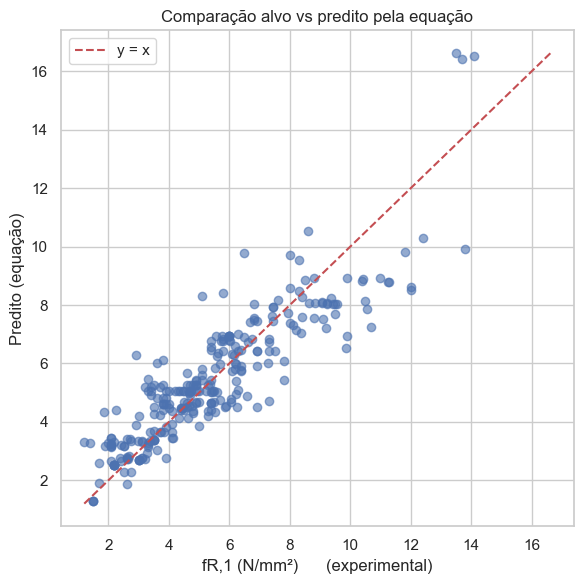

Arquivo 'comparacao_equacao_vs_alvo.csv' salvo.


In [8]:
# Teste: aplicar a equação (unidades originais) linha a linha e comparar com o alvo da planilha (robusto a reordenações)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, r2_score

# 1) Definir a lista esperada de features (mesma da célula de treino)
expected_features = [
    'fck (resistência)            [MPa]',
    'l (comprimento)            [mm]',
    'd (diâmetro            [mm]',
    'l/d      (fator de forma             ',
    'Teor de fibra (%)',
    'N (ganchos)'
]

# 2) Recuperar as colunas presentes em 'work' (construído na célula de treino)
if 'work' not in globals():
    raise RuntimeError("A variável 'work' não existe. Execute antes a célula de treino.")

actual_features = [c for c in expected_features if c in work.columns]
missing_feats = [c for c in expected_features if c not in work.columns]
if missing_feats:
    print('Aviso: as seguintes features esperadas não estão presentes em work e serão ignoradas:', missing_feats)

# 3) Construir X_eq com as colunas atuais e selecionar os coeficientes correspondentes pela posição em feature_cols
if 'feature_cols' not in globals():
    raise RuntimeError("A variável 'feature_cols' não existe. Execute antes a célula de treino.")

# Mapear índices das features atuais dentro de feature_cols
indices = []
for f in actual_features:
    if f in feature_cols:
        indices.append(feature_cols.index(f))
    else:
        print(f"Aviso: '{f}' não está em feature_cols; será ignorada no teste.")
actual_features = [actual_features[i] for i in range(len(actual_features)) if (i < len(indices))]

# Selecionar colunas e coeficientes alinhados
X_eq = work[actual_features].copy().fillna(work[actual_features].median(numeric_only=True))
coefs_sel = np.array([adjusted_coefs[i] for i in indices], dtype=float)

# 4) y verdadeiro do alvo escolhido na célula de treino
if 'target_col' not in globals():
    raise RuntimeError("A variável 'target_col' não existe. Execute antes a célula de treino.")
y_true = work[target_col].copy()

# 5) Predição via equação
if X_eq.shape[1] != coefs_sel.shape[0]:
    raise RuntimeError(f"Desalinhamento: X_eq tem {X_eq.shape[1]} colunas e coefs_sel tem {coefs_sel.shape[0]} coeficientes. Re-execute a célula de treino.")

y_hat = adjusted_intercept + np.dot(X_eq.values, coefs_sel)

# 6) Métricas e comparação
mae_eq = mean_absolute_error(y_true, y_hat)
r2_eq = r2_score(y_true, y_hat)
print(f"MAE (equação): {mae_eq:.4f}  |  R2 (equação): {r2_eq:.4f}")

comp = pd.DataFrame({
    'y_true': y_true.values,
    'y_hat_equacao': y_hat,
    'erro (y_true - y_hat)': y_true.values - y_hat,
})
print('\nAmostra da comparação:')
display(comp.head(10))

# 7) Gráfico y_true vs y_hat
plt.figure(figsize=(6,6))
plt.scatter(y_true, y_hat, alpha=0.6)
mn = min(y_true.min(), y_hat.min())
mx = max(y_true.max(), y_hat.max())
plt.plot([mn,mx],[mn,mx],'r--', label='y = x')
plt.xlabel(target_col)
plt.ylabel('Predito (equação)')
plt.title('Comparação alvo vs predito pela equação')
plt.legend()
plt.tight_layout()
plt.show()

# 8) Salvar CSV
dest = 'comparacao_equacao_vs_alvo.csv'
comp.to_csv(dest, index=False, encoding='utf-8')
print(f"Arquivo '{dest}' salvo.")